# **Notebook created with goal of practicing NLP with Transformers knowledge, with basis on instructions from DEEP LEARNING with Python (Second edition)**

# ***Preparing the IMDB movie reviews data***



## Dataset download


In [1]:
import logging, os

# Trying to get rid of annoying CUDA warnings
os.environ["CUDA_LAUNCH_BLOCKING"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_DEVICE_WAITS_ON_EXCEPTION"] = "2"

In [2]:
!curl -O https:/ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz # The updated format
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9448k      0  0:00:08  0:00:08 --:--:-- 8200k


## Useless subdirectory removal



In [3]:
!rm -r aclImdb/train/unsup

## Data verification

In [4]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

## Validation set preparation
Creating a new directory that contains 20% of training text files

In [5]:
import random
import shutil
import pathlib

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir/"val"
train_dir = base_dir/"train"
test_dir = base_dir/"test"

for category in ("neg", "pos"): # Moves the content from test dir to train dir, to reorganize the dataset
  files = os.listdir(test_dir/category)
  for fname in files:
    if fname.endswith(".txt"):
            # Adds '_t' at the end of file to avoid overlay
            new_fname = fname.replace(".txt", "_t.txt")
            old_path = test_dir/category/fname
            new_path = train_dir/category/new_fname
            shutil.move(old_path, new_path)
  print(f'Train_dir for {category}: {len(os.listdir(train_dir/category))}')
print("\n")

for category in ("neg", "pos"): # Reorganizes the dataset
  os.makedirs(val_dir/category, exist_ok=True)
  files = os.listdir(train_dir/category)

  random.Random(1337).shuffle(files) # Shuffle using a seed

  num_val_samples = int(0.2 * len(files)) # Take 20% for validation
  print(f'Num_val_samples for {category}:{num_val_samples}')
  num_test_samples = int(0.2 * len(files)) # Take 20% for test
  print(f'Num_test_samples for {category}:{num_test_samples}')

  val_files = files[:num_val_samples] # Takes the first 'num_val_samples' files before the num_test_samples
  test_files = files[num_val_samples:num_val_samples+num_test_samples] # Takes the first 'num_test_samples' files for test

  for fname in val_files: # Moves them to their respective new directories
    shutil.move(train_dir/category/fname,
                val_dir/category/fname)
  for fname in test_files:
    shutil.move(train_dir/category/fname,
                test_dir/category/fname)

Train_dir for neg: 25000
Train_dir for pos: 25000


Num_val_samples for neg:5000
Num_test_samples for neg:5000
Num_val_samples for pos:5000
Num_test_samples for pos:5000


## Datasets objects for text



In [6]:
from tensorflow import keras

text_gen = keras.utils

batch_size = 16

train_ds = text_gen.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
    )
val_ds = text_gen.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
    )
test_ds = text_gen.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
    )

Found 30000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.


## Displaying the shapes and dtypes of the first batch

In [7]:
for inputs, targets in train_ds:
  print(f'inputs.shape: {inputs.shape}')
  print(f'inputs.dtype: {inputs.dtype}')
  print(f'targets.shape: {targets.shape}')
  print(f'targets.dtype: {targets.dtype}')
  print(f'inputs[0]: {inputs[0]}')
  print(f'targets[0]: {targets[0]}\n')
  break

inputs.shape: (16,)
inputs.dtype: <dtype: 'string'>
targets.shape: (16,)
targets.dtype: <dtype: 'int32'>
inputs[0]: b"An absolutely brilliant show. The second season began where the first ended, with much mystery. Suspense in most, if not all episodes and mystery everywhere. One that made me think and think again. It's truly amazing how the writer can come out with all the connections and link all the characters together and combine all these elements to make the lives of the characters in the show so meaningful. Never fail to excites and I am looking forward to the new season. Hopefully more secrets will be reveal and at the same time, more mystery to be solved. Good selection of cast too for this show, fit the characters perfectly. Really can't wait to finally discover the secret. Hopefully all the hype won't spoil the ending."
targets[0]: 1



# ***Processing words as a sequence: The sequence model approach***
Get civilized and value word order please

##  Preparing integer sequence datasets

In [8]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="int",
    output_sequence_length=600
)

text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorization.adapt(text_only_train_ds)


int_train_ds = train_ds.map(
    lambda x,y: ((text_vectorization(x)), y),
    num_parallel_calls=4
)

int_val_ds = val_ds.map(
    lambda x,y: ((text_vectorization(x)), y),
    num_parallel_calls=4
)

int_test_ds = test_ds.map(
    lambda x,y: ((text_vectorization(x)), y),
    num_parallel_calls=4
)

# ***The Transformer architecture (or the first half of it)***
You see, this monster uses the idea of self-attention and multi-heads to enhance learning of semantic relationship of words. Mixing Embedding in its architecture, you create a very powerfull machine that could be only imagined in the late 80's: a computer capable of understand humans in natural language.

 ## Transformer encoder implemented as a subclassed Layer

In [9]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

@keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim # Size of input token vectors
    self.dense_dim = dense_dim # Size of the inner denser layer
    self.num_heads = num_heads # Number of attention heads

    # Attention layer
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim
    )

    # Dense projections
    self.dense_proj = keras.Sequential([
        layers.Dense(dense_dim, activation="relu",
                     bias_regularizer=keras.regularizers.L2(1e-6),
                     kernel_regularizer=keras.regularizers.L2(1e-6),
                     activity_regularizer=keras.regularizers.L2(1e-7),
                     kernel_initializer=keras.initializers.HeNormal(seed=123)),
        layers.Dense(embed_dim)
    ])

    # Layer normalizations
    self.layernomr_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def build(self, input_shape):
    super(TransformerEncoder, self).build(input_shape) # Calling build from the superclass to initialize all sublayers. (Avoid warning)

  def call(self, inputs, mask=None): # Model building
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention( # The self attention (key and query must have the same dims, but values can have different dim)
        inputs, inputs, attention_mask=mask
    )
    proj_input = self.layernomr_1(inputs + attention_output) # Layer Normalization after attention mechanism and the residual connection
    proj_output = self.dense_proj(proj_input) # The dense projection
    return self.layernorm_2(proj_input + proj_output) # Another layer normalization after dense projection and the residual connection

  def get_config(self): # Implementation of serialization to save the custom class
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
    })
    return config

## Using the Transformer encoder for text classification (without the positional emdedding)

In [10]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * float(tf.math.exp(-0.1))

In [11]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 128

inputs = layers.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim,
                     embeddings_regularizer=keras.regularizers.L1L2(1e-4),
                     embeddings_initializer=keras.initializers.HeNormal(seed=1))(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x) # Transformer returns full sequences, with need to reduce each sequence to a single vector for classification
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs,outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 256)           │         593,024 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,713,281 (21.79 MB)

 Trainable params: 5,713,281 (21.79 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = [LearningRateScheduler(scheduler),
             ModelCheckpoint("transformer_encoder.keras", monitor='val_loss', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7365 - loss: 0.8450
Epoch 1: val_loss improved from inf to 0.48348, saving model to transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - accuracy: 0.7366 - loss: 0.8447 - val_accuracy: 0.8737 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8760 - loss: 0.4793
Epoch 2: val_loss improved from 0.48348 to 0.46597, saving model to transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.8760 - loss: 0.4793 - val_accuracy: 0.8830 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 3/30
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8933 - loss: 0.4418
Epoch 3: val_loss improved from 0.46597 to 0.45959, saving model to transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.8933 - loss: 0.4418 - val_accuracy: 0.8824 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 4/30
1874/1875

Accuracy:
loss: 0.3347 - accuracy: 92.79%
Validation:
loss: 0.4336 - accuracy: 88.71%
Test:
loss: 0.4323 - accuracy: 88.91%


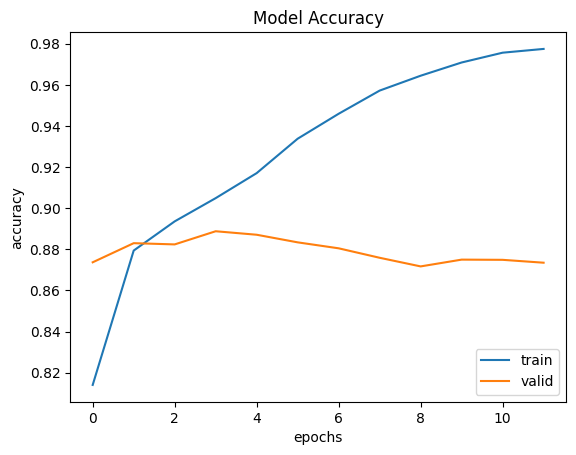

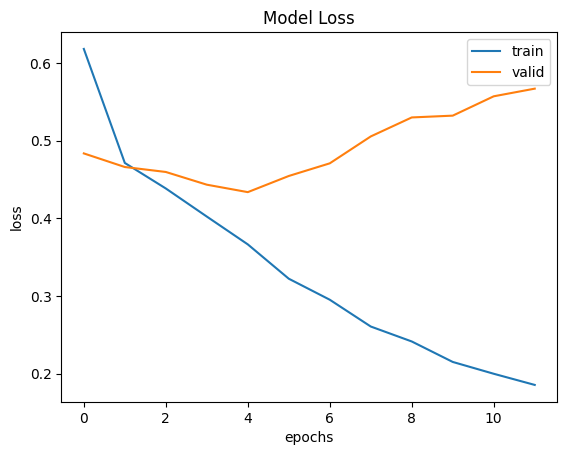

In [13]:
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

model = load_model("transformer_encoder.keras",
                   custom_objects={"TransformerEnconder": TransformerEncoder})

print("Accuracy:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

print("Validation:")
scores = model.evaluate(int_val_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

print("Test:")
scores = model.evaluate(int_test_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Implementing positional embedding as a subclassed layer

In [14]:
import keras.ops as ops

@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs): # Sequence lenght need to be know in advance
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding( # layer for token indices with the vocab size
        input_dim=input_dim, output_dim=output_dim,
        embeddings_regularizer=keras.regularizers.L1L2(1e-4),
        embeddings_initializer=keras.initializers.HeNormal(seed=1)
    )
    self.position_embeddings = layers.Embedding( # layer for the token positions with the input sequence_length
        input_dim=sequence_length, output_dim=output_dim,
        embeddings_regularizer=keras.regularizers.L1L2(1e-4),
        embeddings_initializer=keras.initializers.HeNormal(seed=1)
    )
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def build(self, input_shape):
    super(PositionalEmbedding, self).build(input_shape) # Calling build from the superclass to initialize all sublayers. (Avoid warning)

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions # Add vectors together

  def compute_mask(self, inputs, mask=None): # The mask will get propagated by the framework
    if mask is None:
      return None
    else:
      return ops.not_equal(inputs, 0)

  def get_config(self):
    config = super().get_config()
    config.update({
        "output_dim": self.output_dim,
        "sequence_length": self.sequence_length,
        "input_dim": self.input_dim
    })
    return config

## ***Now this is the (first half) CLASSIFICATION TRANSFORMER***

In [15]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 128

inputs = layers.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) # Here is the difference
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs,outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding                 │ (None, None, 256)           │       5,273,600 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ (None, None, 256)           │         593,024 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,866,881 (22.38 MB)

 Trainable params: 5,866,881 (22.38 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [LearningRateScheduler(scheduler),
             ModelCheckpoint("full_transformer_encoder.keras", monitor='val_loss', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6554 - loss: 1.0296
Epoch 1: val_loss improved from inf to 0.50513, saving model to full_transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.6554 - loss: 1.0295 - val_accuracy: 0.8561 - val_loss: 0.5051 - learning_rate: 0.0010
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8647 - loss: 0.4923
Epoch 2: val_loss improved from 0.50513 to 0.49815, saving model to full_transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.8647 - loss: 0.4923 - val_accuracy: 0.8673 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 3/30
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8903 - loss: 0.4332
Epoch 3: val_loss improved from 0.49815 to 0.46018, saving model to full_transformer_encoder.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.8903 - loss: 0.4332 - val_accuracy: 0.8846 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch

Accuracy:
loss: 0.3611 - accuracy: 91.63%
Validation:
loss: 0.4449 - accuracy: 88.35%
Test:
loss: 0.4450 - accuracy: 88.66%


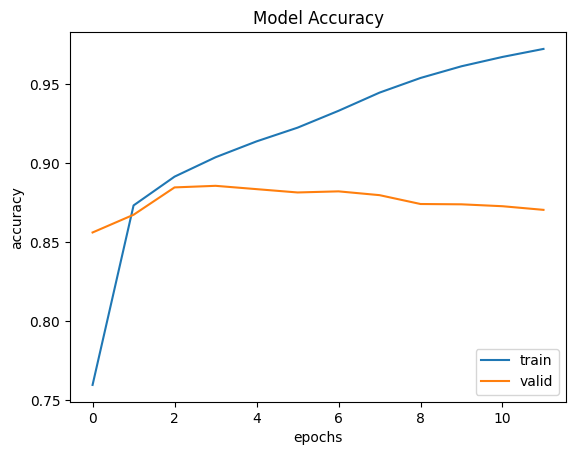

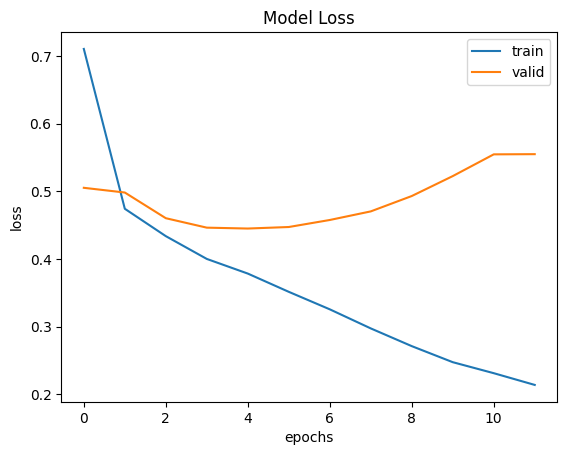

In [17]:
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

model = load_model("full_transformer_encoder.keras",
                   custom_objects={"TransformerEnconder": TransformerEncoder,
                                   "PositionalEmbedding": PositionalEmbedding})

print("Accuracy:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

print("Validation:")
scores = model.evaluate(int_val_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

print("Test:")
scores = model.evaluate(int_test_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# ***Beyond text classification: Sequence-to-sequence learning***
A sequence-to-sequence model takes a sequence as input and translate to another different sequence. Like:


*  *Machine translation*
*  *Text summarization*
*  *Question answering*
*  *Chatbots*
*  *Text generation*



# ***A machine translation example***

## Preparing the dataset: English-to-Spanish translation dataset

In [40]:
base_dir = pathlib.Path("spa-eng")

# Verifies the directory existence
if base_dir.exists() and base_dir.is_dir():
    shutil.rmtree(base_dir)  # Destroys it

In [41]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2024-10-13 01:17:21--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.008s  

2024-10-13 01:17:21 (321 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [42]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
  lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines: # Iterate over the lines in the file
  english, spanish = line.split("\t") # Each line contains an English phrase and its Spanish translation, tab-separated
  spanish = "[start] " + spanish + " [end]" # We add [start] and [end] to the Spanish sentence
  text_pairs.append((english, spanish))

## Shuffle into usual training, validation and testing sets

In [43]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples] # Goes from the first to the num_train_sample position
val_pairs = text_pairs[num_train_samples: num_train_samples + num_val_samples] # Goes from num_train_sample to the sum of num_train and num_val
test_pairs = text_pairs[num_train_samples + num_val_samples:] # From num_val to end

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [44]:
import tensorflow as tf
from keras import layers
import string
import re

strip_chars = string.punctuation + "¿" # Adds the '¿' character to punctuation for striping

# Eliminates '[]' from the punctuation
strip_chars = strip_chars.replace("[","")
strip_chars = strip_chars.replace("]","")

def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, f'[{re.escape(strip_chars)}]', '') # Replaces the entire punctuation with '' for striping

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization( # English
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    )

target_vectorization = layers.TextVectorization( # Spanish
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # The addition of [start] and [end] in input and output, respectively
    standardize = custom_standardization,
    )

train_english_text = [pair[0] for pair in train_pairs]
train_spanish_text = [pair[1] for pair in train_pairs]

source_vectorization.adapt(train_english_text)
target_vectorization.adapt(train_spanish_text)

In [45]:
batch_size = 32

def format_dataset(eng, spa):
  eng = source_vectorization(eng)
  spa = target_vectorization(spa)
  return ({
      "english": eng,
      "spanish": spa[:, :-1], # The tensor is the shape of (64, 20), and we wanna remove the las word of sentence, [end]
  }, spa[:, 1:]) # The target Spanish is one step ahead. Both are still the same lenght (20 words)

def make_dataset(pairs):
  eng_texts, spa_texts = zip(*pairs)
  eng_texts = list(eng_texts)
  spa_texts = list(spa_texts)

  dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts)) # Put the data in a efficient generator structure
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset, num_parallel_calls=4)

  return dataset.shuffle(2048).prefetch(16).cache() # Speed up preprocessing with caching

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [46]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["english"].shape: {inputs["english"].shape}')
    print(f'inputs["spanish"].shape: {inputs["spanish"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["english"].shape: (32, 20)
inputs["spanish"].shape: (32, 20)
targets.shape: (32, 20)


## Sequence-to-sequence learning with Transformer

Now we'll build the second parte that creates the Transformer architecture, the *Transformer decoder*

In [47]:
@keras.utils.register_keras_serializable()
class TransformerDecoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation='relu',
                     bias_regularizer=keras.regularizers.L2(1e-5),
                     kernel_regularizer=keras.regularizers.L2(1e-5),
                     activity_regularizer=keras.regularizers.L2(1e-5),
                     kernel_initializer=keras.initializers.HeNormal(seed=123)),
         layers.Dense(embed_dim)]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking = True # It ensures that the layer will propagate its input mask to its outputs

    def build(self, input_shape):
      super(TransformerDecoder, self).build(input_shape) # Calling build from the superclass to initialize all sublayers. (Avoid warning)

  def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length, = input_shape[0], input_shape[1]

    i = tf.range(sequence_length)[:, tf.newaxis] # Creates a new tensor with shape (sequence_length, 1)
    j = tf.range(sequence_length) # Creates a new tensor with shape (sequence_length)

    mask = tf.cast(i >= j, dtype="int32") # Compares i and j, returning a new matrix with shape(sequence_length, sequence_length)
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1])) # Reshape into a 3D tensor with shape (1, sequence_length, sequence_length)

    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), # Expands batch size in one dimension, with shape (1,) and content [batch_size] (1D)
         tf.constant([1,1], dtype=tf.int32)], # Creates a tensor [1, 1] with shape (2,), (1D)
         axis=0 # Concatenates the vectors, creating a new vector [batch_size, 1, 1] with shape (3,) and 1D
    )
    return tf.tile(mask, mult) # Input: the tensor you wanna replicate.
                               # Multiples: a list or tensor that specifies how many times the input should be replicated along each dimension.
                               # Note: the multiples must have the same number of dimensions as the input tensor.
                               # In another words: input.shape == len(multiples)
                               # In that case, input = (1, sequence_length, sequence_length) and multiplies = [batch_size, 1, 1]

  def call(self, inputs, encoder_outputs, mask=None):
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(
          mask[:, tf.newaxis, :], dtype="int32" # Adds a new dimension to replicate over num of attention heads
                                                # That means: (batch_size, 1, seq_length) == (batch_size, num_heads, seq_length)
                                                # Note: this mask applies only on the S (source) during cross-attention
      )
      padding_mask = tf.minimum(padding_mask, causal_mask) # For each position, returns the minimum between the padding and causal masks by broadcasting
    else:
        padding_mask = None

    attention_output_1 = self.attention_1( # Self-attention
        query=inputs,
        value=inputs,
        key=inputs,
        attention_mask=causal_mask, # Causal mask to avoid cheating
    )
    attention_output_1 = self.layernorm_1(inputs + attention_output_1)
    attention_output_2 = self.attention_2( # Cross-attention
        query=attention_output_1, # The Target generated until now
        value=encoder_outputs, # The Source from encoder
        key=encoder_outputs, # The Source from encoder
        attention_mask=padding_mask, # Padding mask applied over the Source to avoid junk into the query x key
    )
    attention_output_2 = self.layernorm_2(
        attention_output_1 + attention_output_2
    )
    proj_output = self.dense_proj(attention_output_2)

    return self.layernorm_3(attention_output_2 + proj_output)

  def get_config(self): # Implementation of serialization to save the custom class
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
    })
    return config

## End-to-end Transformer

In [48]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) # Encode the soure sentence

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs) # Encode the target sentence and combine it with the encoded source sentence.
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # Predict a word for each output position

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Training the sequence-tosequence Transformer

In [49]:
callbacks = [LearningRateScheduler(scheduler),
             ModelCheckpoint("end-to-end_transformer.keras", monitor='val_loss', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=7)]

transformer.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = transformer.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
2601/2603 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7003 - loss: 2.8508
Epoch 1: val_loss improved from inf to 1.77601, saving model to end-to-end_transformer.keras
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - accuracy: 0.7003 - loss: 2.8501 - val_accuracy: 0.7523 - val_loss: 1.7760 - learning_rate: 0.0010
Epoch 2/30
2602/2603 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7629 - loss: 1.7045
Epoch 2: val_loss improved from 1.77601 to 1.45740, saving model to end-to-end_transformer.keras
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.7629 - loss: 1.7044 - val_accuracy: 0.7953 - val_loss: 1.4574 - learning_rate: 0.0010
Epoch 3/30
2602/2603 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8032 - loss: 1.3933
Epoch 3: val_loss improved from 1.45740 to 1.29458, saving model to end-to-end_transformer.keras
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - accuracy: 0.8032 - loss: 1.3932 - val_accuracy: 0.8234 - val_loss: 1.2946 - learning_rate: 0.0010
Epoch 4/30


Accuracy:
loss: 0.6828 - accuracy: 89.89%


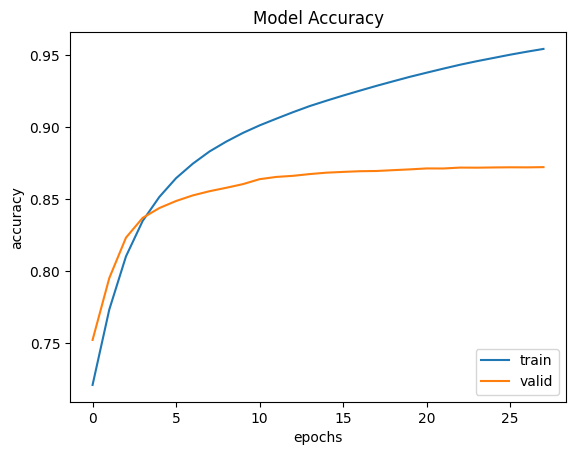

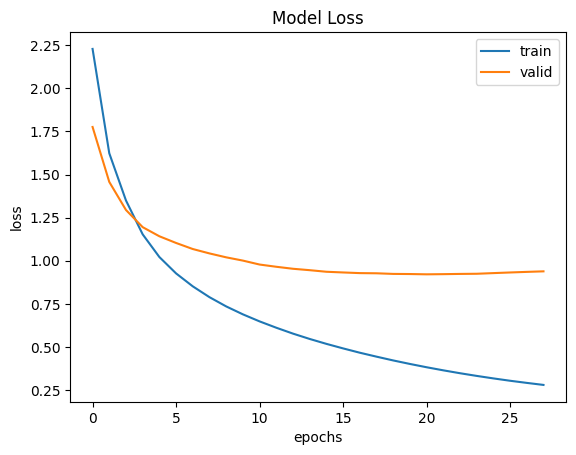

In [55]:
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

model = load_model("end-to-end_transformer.keras",
                   custom_objects={"TransformerEnconder": TransformerEncoder,
                                   "PositionalEmbedding": PositionalEmbedding,
                                   "TransformerDecoder": TransformerDecoder})

print("Accuracy:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [53]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sequence_length = 20

def decode_sequence(input_sequence):
    tokenized_input_sentence = source_vectorization([input_sequence]) # Vectorizing the english source
    decoded_sentence = "[start]" # Points the start of output (target) sequence
    model = load_model("end-to-end_transformer.keras",
                        custom_objects={"TransformerEnconder": TransformerEncoder,
                                   "PositionalEmbedding": PositionalEmbedding,
                                   "TransformerDecoder": TransformerDecoder})

    for i in range(max_decoded_sequence_length):
        # All samples from batch, with exception of last token, wich will be predicted
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence]) # Feed the model

        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :]) # Access the prediction for the 'i' token from batch 0
                                             # Takes all probabilities with ":"
        ).item() # Transforms the tensor into a scalar
        sampled_token = spa_index_lookup[sampled_token_index] # Search for the token in vocab
        decoded_sentence += " " + sampled_token # Joins with the so far decoded sentence

        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, "->", translated)

The Queen's crown was made of gold. -> [start] la [UNK] se hizo [UNK] del oro [end]
She saw him at the station. -> [start] ella lo vio en la estación [end]
I have been reading the book all afternoon. -> [start] tengo que estado leyendo la tarde [end]
He insulted our team. -> [start] Él [UNK] nuestro equipo [end]
Please wait for me. -> [start] por favor espere por mí [end]
She ignored him all day. -> [start] ella lo ignoró todo el día [end]
The only thing that really matters is whether or not you are happy. -> [start] lo único que verdaderamente importa es realmente si no te lo feliz [end]
This play has three acts. -> [start] esta obra tiene tres acondicionado [end]
Salt is used to season food. -> [start] la leche es usado comida [end]
It was just a joke. -> [start] fue pura una broma [end]
Only one thing worries me. -> [start] solo hay una cosa para mí [end]
This is the place where he killed himself. -> [start] Éste es el lugar donde él se encontró [end]
Will you please show me the way